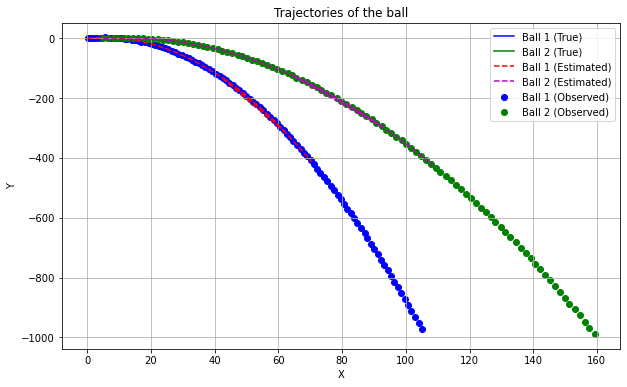

Ball 1 :
RMSE: 206.8879650203605
MSE: 42802.63007026591

Ball 2 :
RMSE: 215.01198296190395
MSE: 46230.15281721007



In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Ball:
    def __init__(self, position_of_launch, speed_of_launch, angle_of_launch):
        self.position_of_launch = np.array(position_of_launch)
        self.speed_of_launch = speed_of_launch
        self.angle_of_launch = angle_of_launch
        self.state = np.concatenate((position_of_launch, self.calculating_of_starting_velocity()), axis=None)
        self.actual_positions = [position_of_launch]
        self.observed_positions = []
        self.estimated_positions = [position_of_launch]
        
    def calculating_of_starting_velocity(self):
        angle_of_launch_rad = np.deg2rad(self.angle_of_launch)
        vx = self.speed_of_launch * np.cos(angle_of_launch_rad)
        vy = self.speed_of_launch * np.sin(angle_of_launch_rad)
        return np.array([vx, vy])
        
    def updation_of_state(self):
        g = 9.81  # acceleration due to gravity
        dt = 0.05  # time step
        # Update position
        self.state[0] += self.state[2] * dt
        self.state[1] += self.state[3] * dt
        # Update velocity
        self.state[2] = self.state[2]
        self.state[3] = self.state[3] - g * dt
        
    def get_position(self):
        return self.state[:2]

def simulate_observation(actual_position, noise_measurement):
    noise = np.random.normal(scale=noise_measurement, size=actual_position.shape)
    return actual_position + noise

def compute_weight(observed_position, final_predicted_position, noise_measurement):
    error = observed_position - final_predicted_position
    likelihood = np.exp(-0.5 * np.sum(error**2) / noise_measurement**2)
    return likelihood

def particle_filter(ball, number_of_particles, noise_measurement, observed_positions_available=True):
    particles = []  # Initialize particles list
    
    for _ in range(num_time_steps):
        # Predict step
        if not particles:
            particles = [np.concatenate((ball.position_of_launch, ball.calculating_of_starting_velocity()), axis=None)
                         for _ in range(number_of_particles)]
        else:
            for i in range(number_of_particles):
                ball.state = particles[i]
                ball.updation_of_state()
                particles[i] = ball.state
        
        # Update step
        observed_positions = []  # positions observed at current time
        
        if observed_positions_available:
            observed_position = simulate_observation(ball.get_position(), noise_measurement)
            ball.observed_positions.append(observed_position)
            observed_positions.append(observed_position)
        
        weights = np.zeros(number_of_particles)
        
        for i in range(number_of_particles):
            ball.state = particles[i]
            ball.updation_of_state()
            final_predicted_position = ball.get_position()
            
            if observed_positions_available:
                observed_position = observed_positions[-1]  # Use the latest observed position
                # Compute weight based on the likelihood of the observed position
                weights[i] = compute_weight(observed_position, final_predicted_position, noise_measurement)
            else:
                # No observation available, assign equal weight to all particles
                weights[i] = 1.0 / number_of_particles
        
        # Resampling step
        if np.sum(weights) != 0.0:
            normalized_weights = weights / np.sum(weights)  # Normalize weights
        else:
            normalized_weights = np.ones(number_of_particles) / number_of_particles  # Assign equal weights if all weights are zero

        indices = np.random.choice(range(number_of_particles), size=number_of_particles, replace=True, p=normalized_weights)
        resampled_particles = [particles[i] for i in indices]

        # Estimate the positions and velocity vectors of the balls from the density
        estimated_positions = np.mean(np.array([particle[:2] for particle in resampled_particles]), axis=0)
        estimated_velocities = np.mean(np.array([particle[2:] for particle in resampled_particles]), axis=0)
        ball.estimated_positions.append(estimated_positions)

        # Update ball state with estimated positions and velocities
        updated_state = np.concatenate((estimated_positions, estimated_velocities), axis=None)
        ball.updation_of_state()



# Set simulation parameters
num_time_steps = 100
number_of_particles = 1000
noise_measurement = 0.1
observed_positions_available = True

# Create ball objects with launch parameters
first_ball = Ball(position_of_launch=[0, 0], speed_of_launch=10, angle_of_launch=45)
second_ball = Ball(position_of_launch=[5, 0], speed_of_launch=12, angle_of_launch=30)

# Run the particle filter for each ball
particle_filter(first_ball, number_of_particles, noise_measurement, observed_positions_available)
particle_filter(second_ball, number_of_particles, noise_measurement, observed_positions_available)

# Generate plots to visualize the results
plt.figure(figsize=(10, 6))

# True trajectories
plt.plot([pos[0] for pos in first_ball.actual_positions], [pos[1] for pos in first_ball.actual_positions], 'b-', label='Ball 1 (True)')
plt.plot([pos[0] for pos in second_ball.actual_positions], [pos[1] for pos in second_ball.actual_positions], 'g-', label='Ball 2 (True)')

# Observed positions
if observed_positions_available:
    plt.scatter([pos[0] for pos in first_ball.observed_positions], [pos[1] for pos in first_ball.observed_positions], color='b', marker='o', label='Ball 1 (Observed)')
    plt.scatter([pos[0] for pos in second_ball.observed_positions], [pos[1] for pos in second_ball.observed_positions], color='g', marker='o', label='Ball 2 (Observed)')

# Estimated trajectories
plt.plot([pos[0] for pos in first_ball.estimated_positions], [pos[1] for pos in first_ball.estimated_positions], 'r--', label='Ball 1 (Estimated)')
plt.plot([pos[0] for pos in second_ball.estimated_positions], [pos[1] for pos in second_ball.estimated_positions], 'm--', label='Ball 2 (Estimated)')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectories of the ball')
plt.legend()
plt.grid(True)
plt.show()


#calculating error
def calculate_error(actual_positions, estimated_positions):
    squared_errors = np.sum((actual_positions - estimated_positions) ** 2, axis=1)
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse, mse

# Define the balls and their positions
balls = [
    {
        'actual_positions': np.array(first_ball.actual_positions),
        'estimated_positions': np.array(first_ball.estimated_positions)
    },
    {
        'actual_positions': np.array(second_ball.actual_positions),
        'estimated_positions': np.array(second_ball.estimated_positions)
    }
]

# Calculate RMSE and MSE for each ball
for ball in balls:
    rmse, mse = calculate_error(ball['actual_positions'], ball['estimated_positions'])
    ball['rmse'] = rmse
    ball['mse'] = mse

# Print the results
for i, ball in enumerate(balls):
    print("Ball", i + 1, ":")
    print("RMSE:", ball['rmse'])
    print("MSE:", ball['mse'])
    print()





